In [9]:
import torch
import sklearn
import pandas as pd
import csv

In [10]:
SpamHam = pd.read_csv('spam_ham_dataset.csv')
SpamHam.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [11]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

SpamHam['clean_text'] = SpamHam['text'].apply(clean_text)
SpamHam['clean_text'].head(5)


0    subject enron methanol meter this is a follow ...
1    subject hpl nom for january see attached file ...
2    subject neon retreat ho ho ho we re around to ...
3    subject photoshop windows office cheap main tr...
4    subject re indian springs this deal is to book...
Name: clean_text, dtype: object

In [16]:

def create_vocab(texts):
    vocab = set()
    for text in texts:
        words = text.split()
        vocab.update(words)
    return {word: idx for idx, word in enumerate(sorted(vocab))}

def text_to_bow(text, vocab):
    vector = torch.zeros(len(vocab))
    for word in text.split():
        if word in vocab:
            vector[vocab[word]] += 1
    return vector

vocabulary = create_vocab(SpamHam['clean_text'])
X = torch.stack([text_to_bow(text, vocabulary) for text in SpamHam['clean_text']])
print(X)
y = torch.tensor(SpamHam['label_num'].values)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


tensor([[ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [11.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])
tensor([0, 0, 0,  ..., 0, 0, 1])


In [13]:

class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  
        self.class_log_priors = None
        self.feature_log_probs = None
        self.classes = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = torch.unique(y)
        n_classes = len(self.classes)
        
        class_counts = torch.zeros(n_classes)
        for i, c in enumerate(self.classes):
            class_counts[i] = (y == c).sum()
        self.class_log_priors = torch.log(class_counts) - torch.log(torch.tensor(n_samples))
        
        feature_counts = torch.zeros((n_classes, n_features))
        for i, c in enumerate(self.classes):
            feature_counts[i] = X[y == c].sum(dim=0) + self.alpha
            
        feature_totals = torch.sum(feature_counts, dim=1, keepdim=True)
        self.feature_log_probs = torch.log(feature_counts) - torch.log(feature_totals)
        
        return self
    
    def predict_log_proba(self, X):
        joint_log_likelihood = torch.zeros((X.shape[0], len(self.classes)))
        
        for i, c in enumerate(self.classes):
            joint_log_likelihood[:, i] = self.class_log_priors[i] + torch.matmul(X, self.feature_log_probs[i])
            
        return joint_log_likelihood
    
    def predict(self, X):
        return self.classes[torch.argmax(self.predict_log_proba(X), dim=1)]

mnb = MultinomialNaiveBayes()
mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)

print("Accuracy:", accuracy_score(y_test.numpy(), y_pred.numpy()))
print("\nClassification Report:")
print(classification_report(y_test.numpy(), y_pred.numpy()))

Accuracy: 0.9768115942028985

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       742
           1       0.97      0.95      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



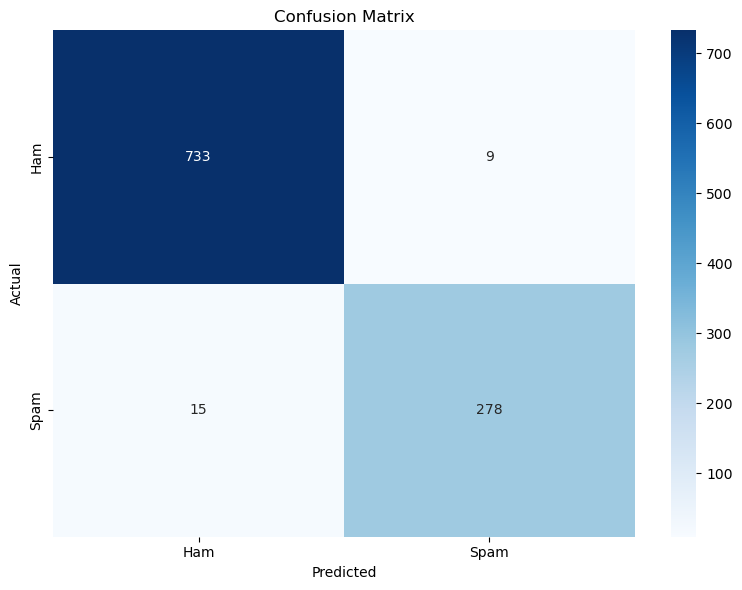

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

cm = confusion_matrix(y_test.numpy(), y_pred.numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()

